# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
df['balance'].isnull().sum()

25

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def change(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
df['balance'] = df['balance'].apply(change)


In [7]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())


In [9]:
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'].value_counts()
df['education'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [11]:
job = df['job'].mode()[0]
educat = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: educat if x == 'unknown' else x)

In [12]:
df['job'].value_counts()
df['education'].value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [13]:
# После замены пропусков рассчитайте средний баланс для клиентов
# с самой популярной работой и самым популярным уровнем образования 
# (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
# Ответ округлите до трёх знаков после точки-разделителя.



In [14]:
df_new = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
df_new['balance'].mean()

1598.8829787234042

### Задание 6

In [15]:
# удалите все выбросы для признака balance
# ваш код
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] >= fence_low) & (df_in[col_name] <= fence_high)]
    print('Нижняя граница =', fence_low, 'Верхняя граница =', fence_high)
    return df_out

In [16]:
new_df = remove_outlier(df, 'balance') # Создали новый data удалив выбросы

Нижняя граница = -2241.0 Верхняя граница = 4063.0


In [17]:
new_df.shape

(10105, 17)

In [18]:
new_df['balance'].describe()

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

### Задание 1

In [19]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df = new_df
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

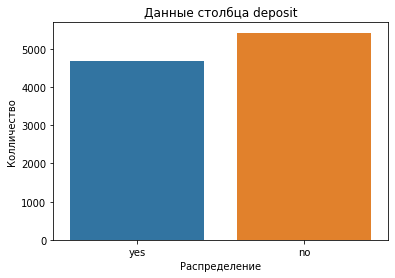

In [20]:
import seaborn as sns 

depos = sns.countplot(df['deposit'])

depos.set_title('Данные столбца deposit')
depos.set_xlabel('Распределение')
depos.set_ylabel('Колличество');

### Задания 2 и 3

In [21]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [22]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0.0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830.0,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545.0,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1.0,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,550.0,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


### Задания 4 и 5

In [23]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df['month'].describe()

count     10105
unique       12
top         may
freq       2617
Name: month, dtype: object

In [24]:
df['job'].describe()

count          10105
unique            11
top       management
freq            2315
Name: job, dtype: object

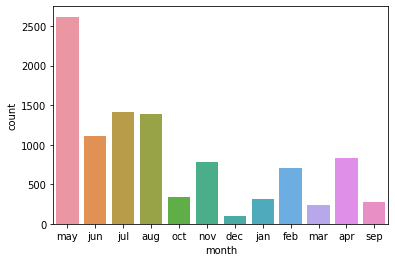

In [25]:
job = sns.countplot(df['month'])
job;

### Задание 6

<AxesSubplot:xlabel='poutcome'>

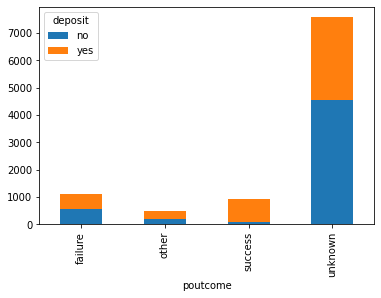

In [26]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

In [27]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
deposit_no = df[df.deposit == 'no'].groupby(['month'])['deposit'].value_counts()
deposit_no

month  deposit
apr    no          317
aug    no          775
dec    no            9
feb    no          323
jan    no          194
jul    no          836
jun    no          606
mar    no           24
may    no         1776
nov    no          456
oct    no           62
sep    no           46
Name: deposit, dtype: int64

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

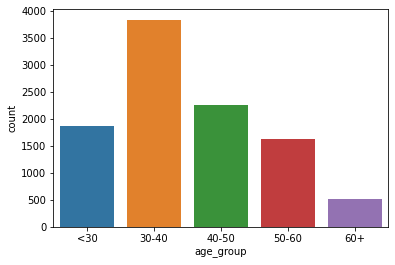

In [28]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x=df.age_group)

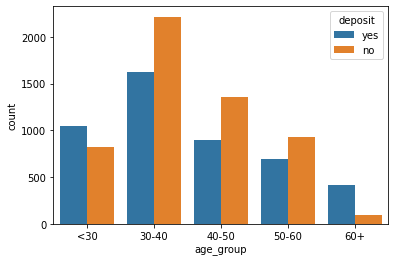

In [29]:
sns.countplot(x='age_group', hue='deposit', data=df);

### Задания 9 и 10

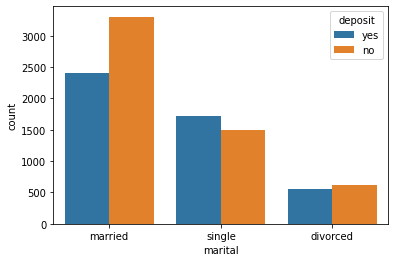

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(x='marital', hue='deposit', data=df);

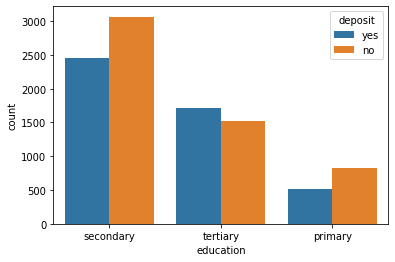

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(x='education', hue='deposit', data=df);

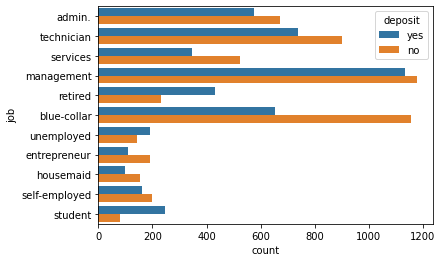

In [32]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=df);

### Задание 11

In [33]:
# # постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# #(если рассматривать тех, кто открыл депозит)
dfyes = df[df.deposit == 'yes']

Cross = pd.crosstab(dfyes['education'], dfyes['marital'])
Cross

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


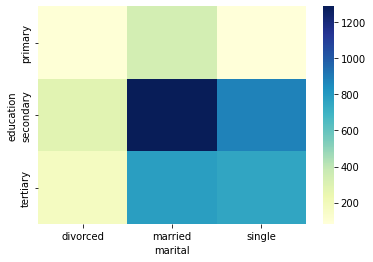

In [34]:
sns.heatmap(Cross,
            cmap='YlGnBu',
            );

## Часть 3: преобразование данных

### Задание 1

In [35]:
# преобразуйте уровни образования
df['education'] = LabelEncoder().fit_transform(df['education'])
df['education'].sum()

11995

In [36]:
df['age_group'] = LabelEncoder().fit_transform(df['age_group'])
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,1


In [37]:
df['deposit'] = LabelEncoder().fit_transform(df['deposit'])

### Задания 2 и 3

In [38]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,0,1


### Задание 4

In [39]:
round(df['deposit'].std(), 3)

0.499

In [40]:
df['default'] = LabelEncoder().fit_transform(df['default'])
df['housing'] = LabelEncoder().fit_transform(df['housing'])
df['loan'] = LabelEncoder().fit_transform(df['loan'])

In [41]:
a = df['default'].mean()
b = df['housing'].mean()
c = df['loan'].mean()
print(round(a+b+c, 3))

0.635


In [42]:
# создайте дамми-переменные
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df1= pd.get_dummies(df[categorial_features])
df = pd.concat([df,df1], axis = 1)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

<AxesSubplot:>

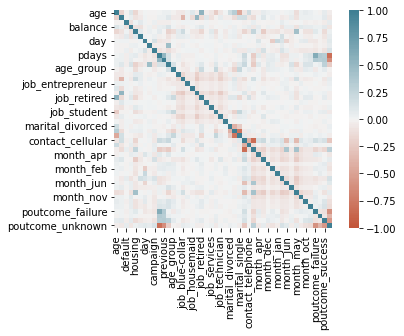

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

In [44]:
corr = df.corr()
new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


### Задания 7 и 8

In [45]:
list_of_drop = ['job', 'marital', 'contact', 'month', 'poutcome']

df = df.drop(list_of_drop, axis=1)

In [46]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [47]:
# рассчитайте необходимые показатели
X_test.shape

y_test.mean()

(3335, 45)

0.46326836581709147

### Задание 9

In [48]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

SelectKBest(k=15)

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [49]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [50]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:, 0].mean()) 

MinMaxScaler()

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [51]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Test accuracy: 0.81


### Задания 2,3,4

In [52]:
# обучите решающие деревья, настройте максимальную глубину
t_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

t_clf_full.fit(X_train_scaled, y_train)

y_train_pred = t_clf_full.predict(X_train_scaled)

print('Test on train  accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

y_test_pred = t_clf_full.predict(X_test_scaled)

print('Test on test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

Test on train  accuracy: 0.82
Test on test accuracy: 0.81


### Задание 5

In [53]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters,
 cv=3, scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print("Наилучшие значения параметров: {}".format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [60]:
# обучите на ваших данных случайный лес

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5, #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)

rf.fit(X_train_scaled, y_train)

y_test_pred = rf.predict(X_test_scaled)

print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))


RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

Test accuracy: 0.83
Test recall: 0.83


### Задания 2 и 3

In [55]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [56]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [57]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [58]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna